In [3]:
                                        ###Loading Data To be PreProcessed###

In [4]:
import json
import math
import time
import re

def read_documents():
    return json.load(open('resources/cranfield_data.json'))


def read_queries():
    return json.load(open('resources/cran.qry.json'))


def read_relevance():
    return json.load(open('resources/cranqrel.json'))

from nltk.tokenize import RegexpTokenizer

'''
    Facilitates implementing regular expression based splitting 
'''
PS = PorterStemmer()

#weights for inlinks, outlinks and comments
INLINKS = 0.6
OUTLINKS = 0.2
COMMENTS = 0.2

""" 
    Takes each word in the given list and stems it according to the Porter's Stemming Algorithm  
"""
def normalizer(l):
    l = list(l)
    lenth=len(l)
    for i in range(0,lenth):
        l[i] = l[i].lower()
        l[i] = PS.stem(l[i],0,len(l[i])-1)

    return l

"""
    _callback and decode_unicode_references will convert all the HTML Entities into characters defined by the ASCII character set.
    This is done using inbuilt functions of the re package
"""

def _callback(matches):
    id = matches.group(1)
    try:
        return unichr(int(id))
    except:
        return id

def decode_unicode_references(data):
    return re.sub("and#(\d+)(;|(?=\s))|&#(\d+)(;|(?=\s))", _callback, data)

def escape(data):
    """HTML-escape the text in `t`."""
    return (data
        .replace("andamp", "&").replace("andlt", "<").replace("andgt", ">")
        .replace("and#39", "'").replace('andquot', '"')
        )

megaList = []
def main():
    var = read_documents()
    tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')

    for i in var:
        ultraList = [] #One Row of the CSV File

        
        title = re.sub('[^\x00-\x7F]','',escape(decode_unicode_references(i["title"])))
        title = tokenizer.tokenize(str(title))
        title = [x.strip('-.?/') for x in title]  
        title = filter(None,title)
        title = normalizer(title)
        ultraList.append(title)
        
        body = re.sub('[^\x00-\x7F]','',escape(decode_unicode_references(i["body"])))
        body = tokenizer.tokenize(str(body))
        body = [x.strip('-.?/;') for x in body]
        body = filter(None,body)
        ultraList.append(normalizer(body))
        megaList.append(ultraList)
        
main()
print("Data has been Loaded !")


Data has been Loaded !


In [5]:
                            ###Building Inverted Index of Title and Body - PreProcessing###

In [6]:
from collections import *

ultraTitle = []
ultraBody = []

def make_unique(l):
    l = set(l) #remove Duplicates
    l = list(l) #convert to list again
    return l

def index1(l,d,k):
    occurences = {}
    for word in l:
        d = {}
        for i in range(len(megaList)):
            temp = [j for j,val in enumerate(megaList[i][k]) if val==word]
            if temp :
                d[i+1] = temp
        occurences[word] = d

    return occurences

for row in megaList:
    for j in row[0]:
        ultraTitle.append(j)
    for j in row[1]:
        ultraBody.append(j)

ultraTitle = make_unique(ultraTitle)
dictTitle = {}
dictTitle = index1(ultraTitle,dictTitle,0)

ultraBody = make_unique(ultraBody)
dictBody = {}
dictBody = index1(ultraBody,dictBody,1)

print("Inverted Index has been Built !")

Inverted Index has been Built !


In [7]:
                            ###Building TFIDF for Title and Body - PreProcessing###

In [8]:
from math import log, pow, sqrt

#dictionaries to hold idf values for words in title and body 
idf_title = {}
idf_body = {}

#dictionaries to hold tf values for words in title and body for each document
tf_title = {}
tf_body = {}

def normalize_query(wt):
    l = 0.0
    for word in wt.keys():
        l = l + pow(wt[word],2)
    l = sqrt(l)
    for word in wt.keys():
        if l != 0:
            wt[word] = wt[word]/l
        else:
            wt[word] = 0.0

def calc_tf_idf(tf,idf,org,N): 	
    for key,val in org.items():
        raw_tf = {}
        #idf value for token 'key'
        idf[key] = (log((float(N)/len(val.keys())),10))  #val.keys() - in how many titles the wor occurred
        for doc_key,doc_val in val.items():
            if len(doc_val)>0:   #if the word is not in start (title words)
                #tf value for token 'key' and document 'doc_key'
                raw_tf[doc_key] = 1 + log(len(doc_val),10)
            else:
                raw_tf[doc_key] = 0
        tf[key] = raw_tf

#calculates tf-idf for title
calc_tf_idf(tf_title,idf_title, dictTitle, len(megaList))
#calculates tf-idf for post
calc_tf_idf(tf_body, idf_body, dictBody, len(megaList))

def normalize_doc(k):
    for i in range(len(megaList)):
        temp = []
        l = 0.0
        for word in megaList[i][k]:
            if word not in temp:
                temp.append(word)
        
        # 1+log(tf); tf -> occurence of word in that document
        # calculating full document to a score
        for word in temp:
            if k == 0:
                l = l + pow(tf_title[word][i+1],2)
            elif k == 1:
                l = l + pow(tf_body[word][i+1],2)
                
        l = sqrt(l)
        for word in temp:
            if k == 0:
                tf_title[word][i] = tf_title[word][i+1]/l
            elif k == 1:
                tf_body[word][i] = tf_body[word][i+1]/l
        
#normalizes title for all documents
normalize_doc(0)
#normalizes body for all documents
normalize_doc(1)

print("TFIDF has been Built !")

TFIDF has been Built !


In [9]:
                                            ###Query Processing###

In [10]:
from nltk.tokenize import RegexpTokenizer

def queryAnalyzer(query):
    tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')
    query = tokenizer.tokenize(query)
    query = [x.strip('-.?/') for x in query]
    query = filter(None,query)
    l = normalizer(query)
    
    return(process_query(l))
    

def process_query(_query):
    
    tf_query = {}
    wt_title = {}
    wt_body = {}

    #calculating raw tf
    for token in _query:
        if token not in tf_query:
            tf_query[token] = 1
        else:
            tf_query[token] = tf_query[token] + 1

    #calculating total weight using the logarithmic formula for tf and multiplying with idf 
    for word in tf_query.keys():
        tf_query[word] = 1 + log(tf_query[word],10)
        if word in idf_title.keys():
            wt_title[word] = tf_query[word]*idf_title[word]
        else:
            wt_title[word] = 0.0
        if word in idf_body.keys():
            wt_body[word] = tf_query[word]*idf_body[word]
        else:
            wt_body[word] = 0.0

    #normalizing query vectors to unit vectors for title, body
    normalize_query(wt_title)
    normalize_query(wt_body)

    title_score = [0]*(len(megaList))
    body_score = [0]*(len(megaList))
    doc_score = [0]*(len(megaList))

    #cosine similiarity with documents w.r.t. title
    for word in wt_title:
        if word in tf_title.keys():
            for doc in tf_title[word]:
                try:
                    title_score[doc] = title_score[doc] + wt_title[word]*tf_title[word][doc]
                except:
                    pass

    #cosine similarity with documents w.r.t body
    for word in wt_body:
        if word in tf_body.keys():
            for doc in tf_body[word]:
                try:
                    body_score[doc] = body_score[doc] + wt_body[word]*tf_body[word][doc]
                except:
                    pass

    #total document score 
    for i in range(len(doc_score)):
        doc_score[i] = title_score[i] + body_score[i]

    return doc_score

In [11]:
var = read_queries()
var2 = read_relevance()

In [12]:
                                ###Here Goes the Interaction - MAIN()###

In [64]:
scor=[]
pres=[]
rec = []
for j in range(225):
    i=var[j]
    queryNum=i["query number"]
    result = queryAnalyzer(i["query"])
    temp=[]
    for j in (var2):
        if(int(j["query_num"])==queryNum):
            temp.append(j["id"])

    retrieved=[]    
    for k in range(5):
        retrieved.append(result.index(max(result)))
        result.remove(result[result.index(max(result))])
    relevant=[]
    for j in (var2):
        if(int(j["query_num"])==queryNum):
            if(int(j["id"]) in retrieved):
                relevant.append(j["id"])
    try:
        precision = len(relevant)/len(retrieved)
        recall = len(relevant)/len(total)
        score=2*((precision*recall)/(precision+recall))
        pres.append(precision)
        rec.append(recall)
        scor.append(score)
        #print(queryNum,"\t",precision, "\t",recall, "\t",score)
    except:
        pass
    
import numpy as np
pres = np.asarray(pres, dtype=np.float32)
rec = np.asarray(rec, dtype=np.float32)

In [65]:
                                            ###Analyze Precision and Recall###

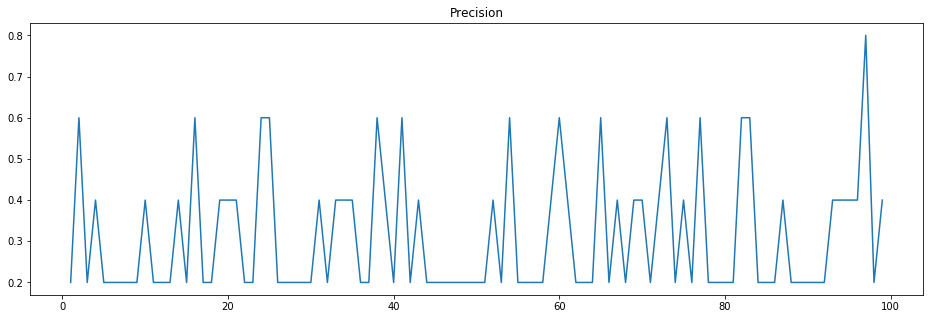

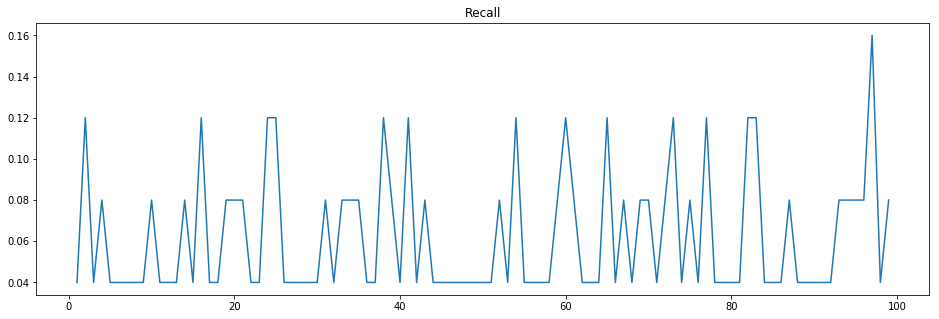

Average Precision: 	 0.31925466480832665
Average Recall: 	 0.0638509302498391


In [66]:
import matplotlib.pyplot as plt

x1=[]
x2=[]
y1=[]
y2=[]

for i in range(1,100):
    x1.append(i)
    y1.append(pres[i])        
for i in range(1,100):
    x2.append(i)
    y2.append(rec[i])    


plt.figure(figsize=(16, 5))
plt.plot(x1, y1)
plt.title("Precision")
plt.show()

plt.figure(figsize=(16, 5))
plt.plot(x2, y2)
plt.title("Recall")
plt.show()

print("Average Precision: \t",sum(pres)/len(pres))
print("Average Recall: \t",sum(rec)/len(rec))

In [67]:
                                            ###Analyze Score###

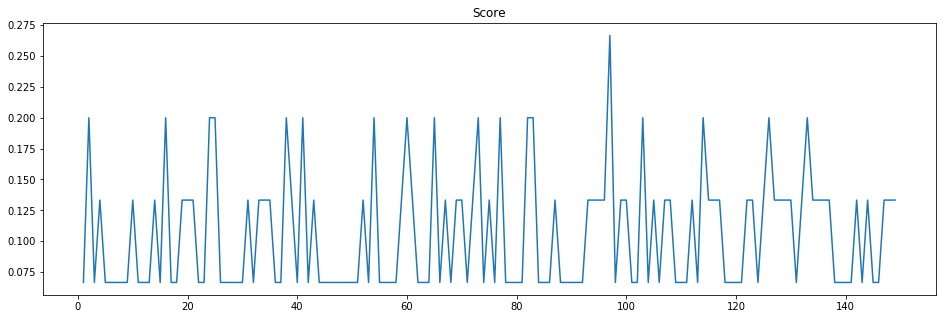

Average F1 score :  0.10641821946169755


In [68]:
import matplotlib.pyplot as plt
x=[]
y=[]
for i in range(1,150):
    x.append(i)
    y.append(scor[i])        

plt.figure(figsize=(16, 5))
plt.plot(x, y)
plt.title("Score")
plt.show()

print("Average F1 score : ",sum(scor)/len(scor))


In [21]:
import sys

class PorterStemmer:

    def __init__(self):
        self.b = ""  # buffer for word to be stemmed
        self.k = 0
        self.k0 = 0
        self.j = 0   # j is a general offset into the string

    def cons(self, i):
        if self.b[i] == 'a' or self.b[i] == 'e' or self.b[i] == 'i' or self.b[i] == 'o' or self.b[i] == 'u':
            return 0
        if self.b[i] == 'y':
            if i == self.k0:
                return 1
            else:
                return (not self.cons(i - 1))
        return 1

    def m(self):
        n = 0
        i = self.k0
        while 1:
            if i > self.j:
                return n
            if not self.cons(i):
                break
            i = i + 1
        i = i + 1
        while 1:
            while 1:
                if i > self.j:
                    return n
                if self.cons(i):
                    break
                i = i + 1
            i = i + 1
            n = n + 1
            while 1:
                if i > self.j:
                    return n
                if not self.cons(i):
                    break
                i = i + 1
            i = i + 1

    def vowelinstem(self):
        """vowelinstem() is TRUE <=> k0,...j contains a vowel"""
        for i in range(self.k0, self.j + 1):
            if not self.cons(i):
                return 1
        return 0

    def doublec(self, j):
        """doublec(j) is TRUE <=> j,(j-1) contain a double consonant."""
        if j < (self.k0 + 1):
            return 0
        if (self.b[j] != self.b[j-1]):
            return 0
        return self.cons(j)

    def cvc(self, i):
        if i < (self.k0 + 2) or not self.cons(i) or self.cons(i-1) or not self.cons(i-2):
            return 0
        ch = self.b[i]
        if ch == 'w' or ch == 'x' or ch == 'y':
            return 0
        return 1

    def ends(self, s):
        """ends(s) is TRUE <=> k0,...k ends with the string s."""
        length = len(s)
        if s[length - 1] != self.b[self.k]: # tiny speed-up
            return 0
        if length > (self.k - self.k0 + 1):
            return 0
        if self.b[self.k-length+1:self.k+1] != s:
            return 0
        self.j = self.k - length
        return 1

    def setto(self, s):
        """setto(s) sets (j+1),...k to the characters in the string s, readjusting k."""
        length = len(s)
        self.b = self.b[:self.j+1] + s + self.b[self.j+length+1:]
        self.k = self.j + length

    def r(self, s):
        """r(s) is used further down."""
        if self.m() > 0:
            self.setto(s)

    def step1ab(self):
        if self.b[self.k] == 's':
            if self.ends("sses"):
                self.k = self.k - 2
            elif self.ends("ies"):
                self.setto("i")
            elif self.b[self.k - 1] != 's':
                self.k = self.k - 1
        if self.ends("eed"):
            if self.m() > 0:
                self.k = self.k - 1
        elif (self.ends("ed") or self.ends("ing")) and self.vowelinstem():
            self.k = self.j
            if self.ends("at"):   self.setto("ate")
            elif self.ends("bl"): self.setto("ble")
            elif self.ends("iz"): self.setto("ize")
            elif self.doublec(self.k):
                self.k = self.k - 1
                ch = self.b[self.k]
                if ch == 'l' or ch == 's' or ch == 'z':
                    self.k = self.k + 1
            elif (self.m() == 1 and self.cvc(self.k)):
                self.setto("e")

    def step1c(self):
        """step1c() turns terminal y to i when there is another vowel in the stem."""
        if (self.ends("y") and self.vowelinstem()):
            self.b = self.b[:self.k] + 'i' + self.b[self.k+1:]

    def step2(self):
        if self.b[self.k - 1] == 'a':
            if self.ends("ational"):   self.r("ate")
            elif self.ends("tional"):  self.r("tion")
        elif self.b[self.k - 1] == 'c':
            if self.ends("enci"):      self.r("ence")
            elif self.ends("anci"):    self.r("ance")
        elif self.b[self.k - 1] == 'e':
            if self.ends("izer"):      self.r("ize")
        elif self.b[self.k - 1] == 'l':
            if self.ends("bli"):       self.r("ble") # --DEPARTURE--
            # To match the published algorithm, replace this phrase with
            #   if self.ends("abli"):      self.r("able")
            elif self.ends("alli"):    self.r("al")
            elif self.ends("entli"):   self.r("ent")
            elif self.ends("eli"):     self.r("e")
            elif self.ends("ousli"):   self.r("ous")
        elif self.b[self.k - 1] == 'o':
            if self.ends("ization"):   self.r("ize")
            elif self.ends("ation"):   self.r("ate")
            elif self.ends("ator"):    self.r("ate")
        elif self.b[self.k - 1] == 's':
            if self.ends("alism"):     self.r("al")
            elif self.ends("iveness"): self.r("ive")
            elif self.ends("fulness"): self.r("ful")
            elif self.ends("ousness"): self.r("ous")
        elif self.b[self.k - 1] == 't':
            if self.ends("aliti"):     self.r("al")
            elif self.ends("iviti"):   self.r("ive")
            elif self.ends("biliti"):  self.r("ble")
        elif self.b[self.k - 1] == 'g': # --DEPARTURE--
            if self.ends("logi"):      self.r("log")
        # To match the published algorithm, delete this phrase

    def step3(self):
        """step3() dels with -ic-, -full, -ness etc. similar strategy to step2."""
        if self.b[self.k] == 'e':
            if self.ends("icate"):     self.r("ic")
            elif self.ends("ative"):   self.r("")
            elif self.ends("alize"):   self.r("al")
        elif self.b[self.k] == 'i':
            if self.ends("iciti"):     self.r("ic")
        elif self.b[self.k] == 'l':
            if self.ends("ical"):      self.r("ic")
            elif self.ends("ful"):     self.r("")
        elif self.b[self.k] == 's':
            if self.ends("ness"):      self.r("")

    def step4(self):
        """step4() takes off -ant, -ence etc., in context <c>vcvc<v>."""
        if self.b[self.k - 1] == 'a':
            if self.ends("al"): pass
            else: return
        elif self.b[self.k - 1] == 'c':
            if self.ends("ance"): pass
            elif self.ends("ence"): pass
            else: return
        elif self.b[self.k - 1] == 'e':
            if self.ends("er"): pass
            else: return
        elif self.b[self.k - 1] == 'i':
            if self.ends("ic"): pass
            else: return
        elif self.b[self.k - 1] == 'l':
            if self.ends("able"): pass
            elif self.ends("ible"): pass
            else: return
        elif self.b[self.k - 1] == 'n':
            if self.ends("ant"): pass
            elif self.ends("ement"): pass
            elif self.ends("ment"): pass
            elif self.ends("ent"): pass
            else: return
        elif self.b[self.k - 1] == 'o':
            if self.ends("ion") and (self.b[self.j] == 's' or self.b[self.j] == 't'): pass
            elif self.ends("ou"): pass
            # takes care of -ous
            else: return
        elif self.b[self.k - 1] == 's':
            if self.ends("ism"): pass
            else: return
        elif self.b[self.k - 1] == 't':
            if self.ends("ate"): pass
            elif self.ends("iti"): pass
            else: return
        elif self.b[self.k - 1] == 'u':
            if self.ends("ous"): pass
            else: return
        elif self.b[self.k - 1] == 'v':
            if self.ends("ive"): pass
            else: return
        elif self.b[self.k - 1] == 'z':
            if self.ends("ize"): pass
            else: return
        else:
            return
        if self.m() > 1:
            self.k = self.j

    def step5(self):
        """step5() removes a final -e if m() > 1, and changes -ll to -l if
        m() > 1.
        """
        self.j = self.k
        if self.b[self.k] == 'e':
            a = self.m()
            if a > 1 or (a == 1 and not self.cvc(self.k-1)):
                self.k = self.k - 1
        if self.b[self.k] == 'l' and self.doublec(self.k) and self.m() > 1:
            self.k = self.k -1

    def stem(self, p, i, j):
        # copy the parameters into statics
        self.b = p
        self.k = j
        self.k0 = i
        if self.k <= self.k0 + 1:
            return self.b # --DEPARTURE--

        # With this line, strings of length 1 or 2 don't go through the
        # stemming process, although no mention is made of this in the
        # published algorithm. Remove the line to match the published
        # algorithm.

        self.step1ab()
        self.step1c()
        self.step2()
        self.step3()
        self.step4()
        self.step5()
        return self.b[self.k0:self.k+1]

print("Stemmer's Algorithm Loaded !")

Stemmer's Algorithm Loaded !
